In [158]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight
from Bio.Alphabet import generic_dna, generic_rna, generic_protein

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import pickle

import sys                                                                         
from gffutils.iterators import DataIterator  
from gtfparse import read_gtf

import copy

# Metadata 

In [2]:
# gencode 25 metadata 
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')

# gencode 35 metadata 
metadata_pc_g35 = pd.read_csv('tmp_res/metadata_pc_g35.txt', sep='\t')

# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [3]:
PhyloSET = pd.read_csv('tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('tmp_res/SET2.txt', sep='\t')

# RiboSET: start-codon local coordinates, all NTE-coordinates 

In [4]:
RiboSET['start_codon_local_coo_start'] = [int(x.split(';')[1].split('-')[0]) for x in RiboSET['Riboseq_Summary'].tolist()]

RiboSET['start_codon'] = [x.split(';')[0] for x in RiboSET['Riboseq_Summary'].tolist()]

tmp = RiboSET[['tr_id', 'gene', 'start_codon_local_coo_start', 'start_codon', 'N_term_end1']]

tmp['start_codon_local_coo_stop'] = tmp['start_codon_local_coo_start'] + 3

tmp.to_csv('tmp_res/RiboSET_local_coo_pred_start.txt', sep='\t', index=False)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# global coo 

In [5]:
def prepare_global_coo(path_to_file_with_global_coo, colname):
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    global_coo_g25_f = global_coo_g25_f[['group_name', 'strand', 'global_coo']].groupby(['group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f.columns = ['tr_id', 'strand', colname]
    return global_coo_g25_f


start_codon_global = prepare_global_coo(path_to_file_with_global_coo='tmp_res/RiboSET_global_coo_pred_start.txt',
                                   colname = 'global_coo_start_codon')

ext_global = prepare_global_coo(path_to_file_with_global_coo='tmp_res/RiboSET_global_coo_pred_start_ext.txt',
                                   colname = 'global_coo_ext')
 
    
RiboSET_coo = RiboSET.merge(ext_global[['tr_id', 'global_coo_ext']].merge(start_codon_global[['tr_id', 'global_coo_start_codon']], on='tr_id', how='inner'), on='tr_id', how='inner')

RiboSET_coo[0:4]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,...,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,start_codon_local_coo_start,start_codon,global_coo_ext,global_coo_start_codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,...,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,98,ATC,chr1:1013520-1013573,chr1:1013520-1013522
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,...,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,173,ACG,chr1:1273666-1273713,chr1:1273711-1273713
2,ENST00000338370.7,AURKAIP1,2,401,133.0,chr1:1374757-1374906,-,chr1:1374757-1375155,-2234.0530,111,...,ATT; 105-402; Rank: 230; cov: 47.87,47.872340,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.063303,105,ATT,chr1:1374757-1375053,chr1:1375051-1375053
3,ENST00000235310.7,MAD2L2,782,929,49.0,chr1:11680602-11680613+chr1:11681039-11681173,-,chr1:11680602-11680613+chr1:11681039-11681173,-2222.6359,111,...,GTG; 861-930; Rank: 321; cov: 55.56,55.555556,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.094194,861,GTG,chr1:11680602-11680613+chr1:11681039-11681095,chr1:11681093-11681095


# COSMIC variants 

In [6]:
cosmic_var = pd.read_csv('data/CosmicNCV.tsv', sep='\t')

cosmic_var.shape[0]

18306185

In [7]:
cosmic_var_f = cosmic_var[['HGVSG', 'Primary site', 'Primary histology', 'Histology subtype 1', 
           'genome position', 'GRCh']]


# make a bed file 

bed = open('tmp_res/cosmic_mut.bed', 'w')


for row in cosmic_var_f.to_numpy():
    if row[-1] == 38:
        pos = row[-2]
        chrom = 'chr'+pos.split(':')[0]
        start = pos.split(':')[1].split('-')[0]
        stop = pos.split(':')[1].split('-')[1]
        
        if int(stop) > int(start): #insertion, take the 1st coo?? + 1
            stop = str(int(start)+1)
        elif int(stop) == int(start):
            stop = str(int(start)+1)
        else:
            continue
            
        score=str(1)
        strand='+'
        name = row[0]
            
        bed.write(chrom+'\t'+start+'\t'+stop+'\t'+name+'\t'+score+'\t'+strand+'\n')

bed.close()

In [ ]:
bed = pd.read_csv('tmp_res/cosmic_mut.bed', sep='\t', header=None).drop_duplicates()
bed.shape[0]

In [ ]:
bed.to_csv('tmp_res/cosmic_mut_no_dup.bed', sep='\t', header=None, index=False)

In [ ]:
! sort -k1,1V -k2,2n -k3,3n tmp_res/cosmic_mut_no_dup.bed > tmp_res/cosmic_mut_no_dup_sorted.bed

In [ ]:
bed_srt = pd.read_csv('tmp_res/cosmic_mut_no_dup_sorted.bed', sep='\t', header=None)
bed_srt[0:4]

In [ ]:
! bedtools intersect -wao -a tmp_res/RiboSET_pred_ext.bed -b tmp_res/cosmic_mut_no_dup_sorted.bed > tmp_res/RiboSET_pred_ext_cosmic.bed

In [ ]:
! bedtools intersect -wao -a tmp_res/RiboSET_pred_start_codon.bed -b tmp_res/cosmic_mut_no_dup_sorted.bed > tmp_res/RiboSET_pred_start_codon_cosmic.bed

# Start codons 

In [8]:
res_start = pd.read_csv('tmp_res/RiboSET_pred_start_codon_cosmic.bed', sep='\t', header=None)

sel = res_start[res_start[5] != -1]

sel.columns = ['chr_codon', 'start_codon', 'stop_codon', 'tr_id', 'chr_var', 'start_var', 'stop_var',
                   'HGVSG', '1', 'strand', 'ovlp']

sel_ann = sel.merge(cosmic_var_f, on=['HGVSG'], how='inner')

print (sel_ann.shape[0])

sel[0:2]

17


,chr_codon,start_codon,stop_codon,tr_id,chr_var,start_var,stop_var,HGVSG,1,strand,ovlp
11,chr1,32817272,32817274,ENST00000373477.8,chr1,32817272,32817273,1:g.32817272C>A,1,+,1
44,chr1,235128851,235128853,ENST00000366607.4,chr1,235128851,235128852,1:g.235128851C>T,1,+,1


# Extension 

## transform genomic coo of mutations to local coo of extension 

In [49]:
res_ext = pd.read_csv('tmp_res/RiboSET_pred_ext_cosmic.bed', sep='\t', header=None)

print (res_ext.shape[0])

sel_ext = res_ext[res_ext[5] != -1]

print (sel_ext.shape[0])

sel_ext.columns = ['chr_codon', 'start_codon_pos', 'stop_codon_pos', 'tr_id', 'chr_var', 'start_var', 'stop_var',
                   'HGVSG', '1', 'strand_', 'ovlp']

sel_ann_ext = sel_ext.merge(cosmic_var_f, on=['HGVSG'], how='inner').drop_duplicates()

print (sel_ann_ext.shape[0])

sel_ann_ext[0:3]

1124
891
970


,chr_codon,start_codon_pos,stop_codon_pos,tr_id,chr_var,start_var,stop_var,HGVSG,1,strand_,ovlp,Primary site,Primary histology,Histology subtype 1,genome position,GRCh
0,chr1,1013520,1013573,ENST00000379389.4,chr1,1013528,1013529,1:g.1013528C>T,1,+,1,lung,carcinoma,adenocarcinoma,1:1013528-1013528,38
1,chr1,1013520,1013573,ENST00000379389.4,chr1,1013531,1013532,1:g.1013531T>C,1,+,1,stomach,carcinoma,adenocarcinoma,1:1013531-1013531,38
2,chr1,1013520,1013573,ENST00000379389.4,chr1,1013559,1013560,1:g.1013559C>T,1,+,1,oesophagus,carcinoma,adenocarcinoma,1:1013559-1013559,38


# Extension -> split into codons -> local coo -> global coo 

In [ ]:
# ext_seq = [CTG, AAA, CGT, ...] -> [5, 8], [8, 11] -> codon1: chr1:4-7, codon2: chr1: 7-10, ...

In [83]:
li = []

for el in sel_ann_ext[['tr_id']].merge(RiboSET[['tr_id', 'start_codon_local_coo_start', 'N_term_end1']]).merge(metadata_pc_g25[['tr_id', 'transcript_seq']], on='tr_id', how='inner').drop_duplicates().to_numpy():
    tr_id = el[0]
    ext_start = el[1]-1
    ext_end = el[2]
    tr_seq = el[3]
    
    ext_seq = tr_seq[ext_start:ext_end]
    
    codons_li = [(i+ext_start, i+3+ext_start, ext_seq[i:i+3]) for i in range(0, len(ext_seq), 3)]
    
    for i, codon in enumerate(codons_li):
        li.append([tr_id, codon[0], codon[1], codon[2]])
    
    
ext_codons_local_coo_df = pd.DataFrame(li, columns = ['tr_id', 'codon_start', 'codon_stop', 'codon_seq'])

ext_codons_local_coo_df['group'] = [i for i in range(1, ext_codons_local_coo_df.shape[0]+1)]

ext_codons_local_coo_df.to_csv('tmp_res/ext_codons_local_coo_cosmic.txt', sep='\t', index=False)

ext_codons_local_coo_df[0:2]

,tr_id,codon_start,codon_stop,codon_seq,group
0,ENST00000379389.4,97,100,ATC,1
1,ENST00000379389.4,100,103,TTT,2


## Open global coo  for codons in extension

In [108]:
def prepare_global_coo_codons(path_to_file_with_global_coo, colname):
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    
    global_coo_g25_f1 = global_coo_g25_f[['group', 'group_name', 'strand', 'global_coo']].groupby(['group', 'group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f1.columns = ['group', 'tr_id', 'strand', colname]
    return global_coo_g25_f1


In [109]:
ext_codons_global = prepare_global_coo_codons(path_to_file_with_global_coo='tmp_res/ext_codons_global_coo_cosmic.txt',
                                   colname = 'global_coo_ext_codons')

In [128]:
# codons at the exon-exon junctions
# very sad
# don't like it 

ext_codons_global[ext_codons_global['global_coo_ext_codons'].str.len()> 50].iloc[-1].global_coo_ext_codons

'chr11:125891471-125891472+chr11:125899344-125899344'

In [114]:
ext_codons_global_local = ext_codons_global.merge(ext_codons_local_coo_df, on=['tr_id', 'group'], how='inner')
ext_codons_global_local[0:2]

,group,tr_id,strand,global_coo_ext_codons,codon_start,codon_stop,codon_seq
0,1,ENST00000379389.4,+,chr1:1013520-1013522,97,100,ATC
1,2,ENST00000379389.4,+,chr1:1013523-1013525,100,103,TTT


In [116]:
res = dict(tuple(ext_codons_global_local.groupby('tr_id')))

In [117]:
res

{'ENST00000014914.5':       group              tr_id strand  \
 4846   4847  ENST00000014914.5      +   
 4847   4848  ENST00000014914.5      +   
 4848   4849  ENST00000014914.5      +   
 4849   4850  ENST00000014914.5      +   
 4850   4851  ENST00000014914.5      +   
 4851   4852  ENST00000014914.5      +   
 4852   4853  ENST00000014914.5      +   
 4853   4854  ENST00000014914.5      +   
 4854   4855  ENST00000014914.5      +   
 4855   4856  ENST00000014914.5      +   
 4856   4857  ENST00000014914.5      +   
 4857   4858  ENST00000014914.5      +   
 
                                 global_coo_ext_codons  codon_start  \
 4846                          chr12:12891636-12891638          854   
 4847                          chr12:12891639-12891641          857   
 4848                          chr12:12891642-12891644          860   
 4849                          chr12:12891645-12891647          863   
 4850                          chr12:12891648-12891650          866   
 4851

### Time to look at the genomic sequences of extensions. Do they correspond to RNA sequence? 

In [ ]:
# make bed file 

bed = open('tmp_res/riboset_Trips_ext_global_coo.bed', 'w')

for el in RiboSET_coo[['global_coo_ext', 'strand', 'tr_id']].to_numpy():
    strand = el[1]
    tr_id = el[-1]
    gl = el[0].split('+')
    
    for interval in gl:
        chrom = interval.split(':')[0].split('chr')[1]
        start = str(int(interval.split(':')[1].split('-')[0])-1)
        stop = interval.split(':')[1].split('-')[1]
        
        bed.write(chrom+'\t'+start+'\t'+stop+'\t'+tr_id+'\t'+str(1)+'\t'+strand+'\n')
        
        
bed.close()

In [ ]:
! sort -k1,1V -k2,2n -k3,3n tmp_res/riboset_Trips_ext_global_coo.bed > tmp_res/riboset_Trips_ext_global_coo_sorted.bed
! bedtools getfasta -name -tab -fi /home/alla/make_PhD_great_again/Pipeline/RNAseq/attempt1/ensemble_hg38_genome/Homo_sapiens.GRCh38.dna.fa -bed tmp_res/riboset_Trips_ext_global_coo_sorted.bed > tmp_res/riboset_Trips_ext_genome_seq.fasta

In [270]:
genomic_fasta_ext = pd.read_csv('tmp_res/riboset_Trips_ext_genome_seq.fasta', sep='\t', header=None)

genomic_fasta_ext['tr_id'] = [x.split(':')[0] for x in genomic_fasta_ext[0].tolist()]

genomic_fasta_ext['chr'] = ['chr'+x.split(':')[2] for x in genomic_fasta_ext[0].tolist()]

genomic_fasta_ext['start'] = [x.split(':')[3].split('-')[0] for x in genomic_fasta_ext[0].tolist()]

genomic_fasta_ext['stop'] = [x.split(':')[3].split('-')[1] for x in genomic_fasta_ext[0].tolist()]

# groupby by transcript and merge sequences

li = []
res = dict(tuple(genomic_fasta_ext.groupby('tr_id')))

for tr_id, df in res.items():
    strand = RiboSET_coo[RiboSET_coo['tr_id'] == tr_id].iloc[0].strand
    if strand == '+':
        fasta = ''.join(df[1].tolist())
    else:
        fasta = str(Seq(''.join(df[1].tolist())[::-1]).complement())
        
    codons = [fasta[i:i+3] for i in range(0, len(fasta), 3)]
    
    for codon in codons:
        
        li.append([tr_id, fasta, codon])
    
    
genomic_ext_seq = pd.DataFrame(li, columns = ['tr_id', 'ext_genomic', 'genomic_codon'])

genomic_ext_seq

,tr_id,ext_genomic,genomic_codon
0,ENST00000014914.5,AAGTTCACGGCCAACGCCTTGGCACTAGGGTCCAGA,AAG
1,ENST00000014914.5,AAGTTCACGGCCAACGCCTTGGCACTAGGGTCCAGA,TTC
2,ENST00000014914.5,AAGTTCACGGCCAACGCCTTGGCACTAGGGTCCAGA,ACG
3,ENST00000014914.5,AAGTTCACGGCCAACGCCTTGGCACTAGGGTCCAGA,GCC
4,ENST00000014914.5,AAGTTCACGGCCAACGCCTTGGCACTAGGGTCCAGA,AAC
...,...,...,...
11843,ENST00000619580.4,CTGCGGGTCTCCGCTCCAGACCCACCCCCGCCCCACCCCGCGCGCC...,CCC
11844,ENST00000619580.4,CTGCGGGTCTCCGCTCCAGACCCACCCCCGCCCCACCCCGCGCGCC...,GGC
11845,ENST00000619580.4,CTGCGGGTCTCCGCTCCAGACCCACCCCCGCCCCACCCCGCGCGCC...,CCC
11846,ENST00000619580.4,CTGCGGGTCTCCGCTCCAGACCCACCCCCGCCCCACCCCGCGCGCC...,GGC


# Iterate over SNPs and codons: assign codon and position in codon (start, middle, end)

In [170]:
# select only SNPs,: no del ins dup 

sel_ann_ext_SNPs = sel_ann_ext[(sel_ann_ext['HGVSG'].str.find('del') == -1) & 
                              (sel_ann_ext['HGVSG'].str.find('ins') == -1) & 
                              (sel_ann_ext['HGVSG'].str.find('dup') == -1)]

sel_ann_ext_insdel = sel_ann_ext[(sel_ann_ext['HGVSG'].str.find('del') != -1) | 
                              (sel_ann_ext['HGVSG'].str.find('ins') != -1) | 
                              (sel_ann_ext['HGVSG'].str.find('dup') != -1)]

print (sel_ann_ext_SNPs.shape[0], sel_ann_ext_insdel.shape[0])

sel_ann_ext_SNPs[0:4]

914 56


,chr_codon,start_codon_pos,stop_codon_pos,tr_id,chr_var,start_var,stop_var,HGVSG,1,strand_,ovlp,Primary site,Primary histology,Histology subtype 1,genome position,GRCh
0,chr1,1013520,1013573,ENST00000379389.4,chr1,1013528,1013529,1:g.1013528C>T,1,+,1,lung,carcinoma,adenocarcinoma,1:1013528-1013528,38
1,chr1,1013520,1013573,ENST00000379389.4,chr1,1013531,1013532,1:g.1013531T>C,1,+,1,stomach,carcinoma,adenocarcinoma,1:1013531-1013531,38
2,chr1,1013520,1013573,ENST00000379389.4,chr1,1013559,1013560,1:g.1013559C>T,1,+,1,oesophagus,carcinoma,adenocarcinoma,1:1013559-1013559,38
3,chr1,1374757,1375053,ENST00000338370.7,chr1,1374760,1374761,1:g.1374760C>A,1,+,1,large_intestine,carcinoma,adenocarcinoma,1:1374760-1374760,38


In [307]:
914+56

970

In [349]:
li = []

res = dict(tuple(ext_codons_global_local.groupby('tr_id')))


for el in sel_ann_ext_SNPs.to_numpy():
    tr_id = el[3]
    chrom = el[4]
    start_var = el[5]
    stop_var = el[6]
    mut = el[7].split('>')[0][-1]+'>'+el[7].split('>')[1]
    HGVSG = el[7]
    
    # iterate over codons in extension 
    df = res[tr_id]
    df['codon_number'] = [x for x in range(0, df.shape[0])]
    df['genomic_codon'] = genomic_ext_seq[genomic_ext_seq['tr_id'] == tr_id]['genomic_codon'].tolist()
    
    
    
    for codon in df.to_numpy():
        global_coo_ext_codons = codon[3]
        strand = codon[2]
        codon_seq = codon[-3]
        codon_numb = codon[-2]
        codon_genome = codon[-1]
        
        # split chr22:49918731-49918733 into [49918731, 49918732, 49918733]
        # split 'chr11:125891471-125891472+chr11:125899344-125899344' into [125891471, 125891472, 125899344] 
        
        if len(global_coo_ext_codons.split('+')) == 1:
            a = int(global_coo_ext_codons.split(':')[1].split('-')[0])
            b = int(global_coo_ext_codons.split(':')[1].split('-')[1])
            all_pos = list(np.arange(a, b+1))
        else:
            l = [x.split(':')[1].split('-') for x in global_coo_ext_codons.split('+')]
            all_pos = sorted(list(set([int(item) for sublist in l for item in sublist])))
            
        # check whether start pos of variant in all_pos of codons
        # write changed codon 
        
        if start_var in all_pos:
            #print (all_pos, )
            pos_of_variant_in_codon = all_pos.index(start_var) # 0, 1, 2
            
            # change that 
            mut_final = mut.split('>')[-1]
            codon_seq_mut = list(codon_seq)
            codon_seq_mut[pos_of_variant_in_codon] = mut_final
            codon_seq_mut = ''.join(codon_seq_mut)
            
            li.append([HGVSG, tr_id, start_var, stop_var, all_pos, 
                       global_coo_ext_codons, strand, codon_seq, codon_seq_mut, 
                       codon_numb, codon_genome, df.shape[0]])
            
ext_changes = pd.DataFrame(li, columns = ['HGVSG', 'tr_id', 'start_var', 'stop_var', 'all_pos', 
                            'global_coo_ext_codons', 'strand', 'codon_seq', 
                           'codon_seq_mut', 'codon_numb', 'codon_genome',
                                         'total_num_codons']).merge(metadata_pc_g25[['tr_id', 'gene']], on='tr_id', how='inner')



print ('# of mut where RNA already has it -> no change in codon', ext_changes[ext_changes['codon_seq'] == ext_changes['codon_seq_mut']].shape[0])

print ('# of mut with change in codon', ext_changes[ext_changes['codon_seq'] != ext_changes['codon_seq_mut']].shape[0])

print ('# of diff codons between RNA and genome', ext_changes[ext_changes['codon_seq'] != ext_changes['codon_genome']].shape[0])

# of mut where RNA already has it -> no change in codon 81
# of mut with change in codon 833
# of diff codons between RNA and genome 0


We selected 914 SMP variants (exluding deletions and insertions) within predicted RiboSET extensions, 81 among them cause no change in codon of extension (becuase such variant exist already in RNA, but not in reference genome used in COSMIC. All studied codons are the same in transcripts and Ensemble hg38 reference genome). 

Remamining variants (56) are either deletion or insersion or duplication. 

## Let's check start codons (1st codons per transcript)

In [350]:
ext_changes[(ext_changes['codon_numb'] == 0) & (ext_changes['codon_seq_mut'] == ext_changes['codon_seq'])]

,HGVSG,tr_id,start_var,stop_var,all_pos,global_coo_ext_codons,strand,codon_seq,codon_seq_mut,codon_numb,codon_genome,total_num_codons,gene
373,6:g.85642948A>T,ENST00000369622.7,85642948,85642949,"[85642947, 85642948, 85642949]",chr6:85642947-85642949,-,GTG,GTG,0,GTG,55,SYNCRIP


In [351]:
ext_changes[(ext_changes['codon_numb'] == 0) & (ext_changes['codon_seq_mut'] != ext_changes['codon_seq'])].shape[0]

24

In [352]:
# we can take a look at genomes and see what letter in them 

### (1) near-cognate change 

In [353]:
near_cognate = ['GTG', 'TTG', 'CTG', 'ATC', 'ATA', 'ATT']
atg = ['ATG']
stops = ['TAG', 'TGA', 'TAA']

In [354]:
all_codons = [item for sublist in list(slc_codon.values()) for item in sublist]

destroy_start_codons = list(set(all_codons) - set(near_cognate+atg+stops))

len(destroy_start_codons)

54

In [355]:
slc_codon = {
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    'F': ['TTT', 'TTC'],
    'M': ['ATG'],
    'C': ['TGT', 'TGC'],
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'Y': ['TAT', 'TAC'],
    'W': ['TGG'],
    'Q': ['CAA', 'CAG'],
    'N': ['AAT', 'AAC'],
    'H': ['CAT', 'CAC'],
    'E': ['GAA', 'GAG'],
    'D': ['GAT', 'GAC'],
    'K': ['AAA', 'AAG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    '*': ['TAA', 'TAG', 'TGA'],
}
codon_slc = dict((x, k) for k, v in slc_codon.items() for x in v)

codon_slc['ATT']

'I'

## add annotation 

In [356]:
ext_changes_ann = ext_changes.merge(sel_ann_ext[['HGVSG', 'Primary site', 'Primary histology', 'Histology subtype 1']], 
                 on='HGVSG', how='inner')

In [357]:
genes_start_to_near_cognate = ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'].isin(near_cognate))].gene.unique()

genes_start_to_ATG = ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'] == 'ATG')].gene.unique()


genes_start_destroyed = ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'].isin(destroy_start_codons))].gene.unique()

genes_start_to_stop = ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'].isin(stops))].gene.unique()


print ('genes_start_to_near_cognate', len(genes_start_to_near_cognate))
print ('genes_start_to_ATG', len(genes_start_to_ATG))
print ('genes_start_destroyed', len(genes_start_destroyed))
print ('genes_start_to_stop', len(genes_start_to_stop))

genes_start_to_near_cognate 9
genes_start_to_ATG 4
genes_start_destroyed 10
genes_start_to_stop 0


In [358]:
ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'] == 'ATG')]

,HGVSG,tr_id,start_var,stop_var,all_pos,global_coo_ext_codons,strand,codon_seq,codon_seq_mut,codon_numb,codon_genome,total_num_codons,gene,Primary site,Primary histology,Histology subtype 1
27,1:g.32817272C>A,ENST00000373477.8,32817272,32817273,"[32817272, 32817273, 32817274]",chr1:32817272-32817274,-,CTG,ATG,0,CTG,10,YARS,urinary_tract,carcinoma,NS
159,3:g.39383692C>A,ENST00000273158.8,39383692,39383693,"[39383692, 39383693, 39383694]",chr3:39383692-39383694,+,CTG,ATG,0,CTG,11,SLC25A38,cervix,carcinoma,squamous_cell_carcinoma
247,4:g.105895605C>A,ENST00000379987.6,105895605,105895606,"[105895605, 105895606, 105895607]",chr4:105895605-105895607,+,CTG,ATG,0,CTG,16,NPNT,endometrium,carcinoma,endometrioid_carcinoma
1010,19:g.5623170C>A,ENST00000292123.9,5623170,5623171,"[5623170, 5623171, 5623172]",chr19:5623170-5623172,+,CTG,ATG,0,CTG,12,SAFB,endometrium,carcinoma,endometrioid_carcinoma


In [359]:
ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'].isin(near_cognate))][['gene', 'Primary site', 'Primary histology', 'Histology subtype 1', 
                                                                   'codon_seq', 'codon_seq_mut']]

,gene,Primary site,Primary histology,Histology subtype 1,codon_seq,codon_seq_mut
102,TOMM20,skin,malignant_melanoma,NS,GTG,TTG
276,CCNB1,cervix,carcinoma,squamous_cell_carcinoma,CTG,TTG
418,CDC42SE2,liver,other,neoplasm,TTG,CTG
526,HEBP2,pancreas,carcinoma,ductal_carcinoma,CTG,TTG
567,PTN,lung,carcinoma,squamous_cell_carcinoma,CTG,TTG
624,RCL1,urinary_tract,carcinoma,NS,ATC,ATT
667,TCF7L2,endometrium,carcinoma,endometrioid_carcinoma,TTG,GTG
789,RDH11,skin,malignant_melanoma,NS,CTG,TTG
1061,PNKP,pancreas,carcinoma,ductal_carcinoma,GTG,TTG


In [363]:
ext_changes_ann[(ext_changes_ann['codon_numb'] == 0) & 
            (ext_changes_ann['codon_seq_mut'] != ext_changes_ann['codon_seq']) & 
            (ext_changes_ann['codon_seq_mut'].isin(destroy_start_codons))][['HGVSG', 'gene', 'Primary site', 'Primary histology', 'Histology subtype 1', 
                                                                   'codon_seq', 'codon_seq_mut']].drop_duplicates()

,HGVSG,gene,Primary site,Primary histology,Histology subtype 1,codon_seq,codon_seq_mut
108,2:g.8682114G>T,ID2,lung,carcinoma,adenocarcinoma,CTG,CTT
140,2:g.202034620G>A,FZD7,thyroid,carcinoma,NS,CTG,CTA
157,3:g.33798685T>A,PDCD6IP,liver,carcinoma,NS,CTG,CAG
261,5:g.271669G>C,PDCD6,liver,carcinoma,NS,CTG,CTC
644,10:g.72274180G>A,DDIT4,thyroid,carcinoma,NS,CTG,CTA
684,11:g.819625G>A,PNPLA2,liver,carcinoma,hepatocellular_carcinoma,CTG,CTA
685,11:g.819625G>A,PNPLA2,liver,carcinoma,NS,CTG,CTA
709,11:g.34051750T>C,CAPRIN1,pancreas,carcinoma,ductal_carcinoma,GTG,GCG
868,16:g.84617979A>G,COTL1,skin,carcinoma,NS,ATC,AGC
884,17:g.1400178C>A,YWHAE,endometrium,carcinoma,endometrioid_carcinoma,AGG,AAG


### make supplementary table with start codons 

In [303]:
ext_changes_ann[ext_changes_ann['codon_numb'] == 0][['tr_id', 'gene', 'HGVSG', 
                                                     'global_coo_ext_codons', 'strand', 'codon_seq', 
                 'codon_seq_mut', 'codon_numb', 'Primary site', 'Primary histology', 
                                                     'Histology subtype 1']].drop_duplicates().to_csv('Supplementary_tables_and_plots/tables/S7_COSMIC_riboset_starts.txt', sep='\t', index=False)


## Then check remaning ones: any coding -> stop? (in-frame stop)? radical substitution?

In [364]:
blosum62 = {
    ('W', 'F'): 1, ('L', 'R'): -2, ('S', 'P'): -1, ('V', 'T'): 0,
    ('Q', 'Q'): 5, ('N', 'A'): -2, ('Z', 'Y'): -2, ('W', 'R'): -3,
    ('Q', 'A'): -1, ('S', 'D'): 0, ('H', 'H'): 8, ('S', 'H'): -1,
    ('H', 'D'): -1, ('L', 'N'): -3, ('W', 'A'): -3, ('Y', 'M'): -1,
    ('G', 'R'): -2, ('Y', 'I'): -1, ('Y', 'E'): -2, ('B', 'Y'): -3,
    ('Y', 'A'): -2, ('V', 'D'): -3, ('B', 'S'): 0, ('Y', 'Y'): 7,
    ('G', 'N'): 0, ('E', 'C'): -4, ('Y', 'Q'): -1, ('Z', 'Z'): 4,
    ('V', 'A'): 0, ('C', 'C'): 9, ('M', 'R'): -1, ('V', 'E'): -2,
    ('T', 'N'): 0, ('P', 'P'): 7, ('V', 'I'): 3, ('V', 'S'): -2,
    ('Z', 'P'): -1, ('V', 'M'): 1, ('T', 'F'): -2, ('V', 'Q'): -2,
    ('K', 'K'): 5, ('P', 'D'): -1, ('I', 'H'): -3, ('I', 'D'): -3,
    ('T', 'R'): -1, ('P', 'L'): -3, ('K', 'G'): -2, ('M', 'N'): -2,
    ('P', 'H'): -2, ('F', 'Q'): -3, ('Z', 'G'): -2, ('X', 'L'): -1,
    ('T', 'M'): -1, ('Z', 'C'): -3, ('X', 'H'): -1, ('D', 'R'): -2,
    ('B', 'W'): -4, ('X', 'D'): -1, ('Z', 'K'): 1, ('F', 'A'): -2,
    ('Z', 'W'): -3, ('F', 'E'): -3, ('D', 'N'): 1, ('B', 'K'): 0,
    ('X', 'X'): -1, ('F', 'I'): 0, ('B', 'G'): -1, ('X', 'T'): 0,
    ('F', 'M'): 0, ('B', 'C'): -3, ('Z', 'I'): -3, ('Z', 'V'): -2,
    ('S', 'S'): 4, ('L', 'Q'): -2, ('W', 'E'): -3, ('Q', 'R'): 1,
    ('N', 'N'): 6, ('W', 'M'): -1, ('Q', 'C'): -3, ('W', 'I'): -3,
    ('S', 'C'): -1, ('L', 'A'): -1, ('S', 'G'): 0, ('L', 'E'): -3,
    ('W', 'Q'): -2, ('H', 'G'): -2, ('S', 'K'): 0, ('Q', 'N'): 0,
    ('N', 'R'): 0, ('H', 'C'): -3, ('Y', 'N'): -2, ('G', 'Q'): -2,
    ('Y', 'F'): 3, ('C', 'A'): 0, ('V', 'L'): 1, ('G', 'E'): -2,
    ('G', 'A'): 0, ('K', 'R'): 2, ('E', 'D'): 2, ('Y', 'R'): -2,
    ('M', 'Q'): 0, ('T', 'I'): -1, ('C', 'D'): -3, ('V', 'F'): -1,
    ('T', 'A'): 0, ('T', 'P'): -1, ('B', 'P'): -2, ('T', 'E'): -1,
    ('V', 'N'): -3, ('P', 'G'): -2, ('M', 'A'): -1, ('K', 'H'): -1,
    ('V', 'R'): -3, ('P', 'C'): -3, ('M', 'E'): -2, ('K', 'L'): -2,
    ('V', 'V'): 4, ('M', 'I'): 1, ('T', 'Q'): -1, ('I', 'G'): -4,
    ('P', 'K'): -1, ('M', 'M'): 5, ('K', 'D'): -1, ('I', 'C'): -1,
    ('Z', 'D'): 1, ('F', 'R'): -3, ('X', 'K'): -1, ('Q', 'D'): 0,
    ('X', 'G'): -1, ('Z', 'L'): -3, ('X', 'C'): -2, ('Z', 'H'): 0,
    ('B', 'L'): -4, ('B', 'H'): 0, ('F', 'F'): 6, ('X', 'W'): -2,
    ('B', 'D'): 4, ('D', 'A'): -2, ('S', 'L'): -2, ('X', 'S'): 0,
    ('F', 'N'): -3, ('S', 'R'): -1, ('W', 'D'): -4, ('V', 'Y'): -1,
    ('W', 'L'): -2, ('H', 'R'): 0, ('W', 'H'): -2, ('H', 'N'): 1,
    ('W', 'T'): -2, ('T', 'T'): 5, ('S', 'F'): -2, ('W', 'P'): -4,
    ('L', 'D'): -4, ('B', 'I'): -3, ('L', 'H'): -3, ('S', 'N'): 1,
    ('B', 'T'): -1, ('L', 'L'): 4, ('Y', 'K'): -2, ('E', 'Q'): 2,
    ('Y', 'G'): -3, ('Z', 'S'): 0, ('Y', 'C'): -2, ('G', 'D'): -1,
    ('B', 'V'): -3, ('E', 'A'): -1, ('Y', 'W'): 2, ('E', 'E'): 5,
    ('Y', 'S'): -2, ('C', 'N'): -3, ('V', 'C'): -1, ('T', 'H'): -2,
    ('P', 'R'): -2, ('V', 'G'): -3, ('T', 'L'): -1, ('V', 'K'): -2,
    ('K', 'Q'): 1, ('R', 'A'): -1, ('I', 'R'): -3, ('T', 'D'): -1,
    ('P', 'F'): -4, ('I', 'N'): -3, ('K', 'I'): -3, ('M', 'D'): -3,
    ('V', 'W'): -3, ('W', 'W'): 11, ('M', 'H'): -2, ('P', 'N'): -2,
    ('K', 'A'): -1, ('M', 'L'): 2, ('K', 'E'): 1, ('Z', 'E'): 4,
    ('X', 'N'): -1, ('Z', 'A'): -1, ('Z', 'M'): -1, ('X', 'F'): -1,
    ('K', 'C'): -3, ('B', 'Q'): 0, ('X', 'B'): -1, ('B', 'M'): -3,
    ('F', 'C'): -2, ('Z', 'Q'): 3, ('X', 'Z'): -1, ('F', 'G'): -3,
    ('B', 'E'): 1, ('X', 'V'): -1, ('F', 'K'): -3, ('B', 'A'): -2,
    ('X', 'R'): -1, ('D', 'D'): 6, ('W', 'G'): -2, ('Z', 'F'): -3,
    ('S', 'Q'): 0, ('W', 'C'): -2, ('W', 'K'): -3, ('H', 'Q'): 0,
    ('L', 'C'): -1, ('W', 'N'): -4, ('S', 'A'): 1, ('L', 'G'): -4,
    ('W', 'S'): -3, ('S', 'E'): 0, ('H', 'E'): 0, ('S', 'I'): -2,
    ('H', 'A'): -2, ('S', 'M'): -1, ('Y', 'L'): -1, ('Y', 'H'): 2,
    ('Y', 'D'): -3, ('E', 'R'): 0, ('X', 'P'): -2, ('G', 'G'): 6,
    ('G', 'C'): -3, ('E', 'N'): 0, ('Y', 'T'): -2, ('Y', 'P'): -3,
    ('T', 'K'): -1, ('A', 'A'): 4, ('P', 'Q'): -1, ('T', 'C'): -1,
    ('V', 'H'): -3, ('T', 'G'): -2, ('I', 'Q'): -3, ('Z', 'T'): -1,
    ('C', 'R'): -3, ('V', 'P'): -2, ('P', 'E'): -1, ('M', 'C'): -1,
    ('K', 'N'): 0, ('I', 'I'): 4, ('P', 'A'): -1, ('M', 'G'): -3,
    ('T', 'S'): 1, ('I', 'E'): -3, ('P', 'M'): -2, ('M', 'K'): -1,
    ('I', 'A'): -1, ('P', 'I'): -3, ('R', 'R'): 5, ('X', 'M'): -1,
    ('L', 'I'): 2, ('X', 'I'): -1, ('Z', 'B'): 1, ('X', 'E'): -1,
    ('Z', 'N'): 0, ('X', 'A'): 0, ('B', 'R'): -1, ('B', 'N'): 3,
    ('F', 'D'): -3, ('X', 'Y'): -1, ('Z', 'R'): 0, ('F', 'H'): -1,
    ('B', 'F'): -3, ('F', 'L'): 0, ('X', 'Q'): -1, ('B', 'B'): 4
}

In [365]:
blosum62[('F', 'L')], blosum62[('L', 'F')]

KeyError: ('L', 'F')

In [366]:
ext_changes_ann[ext_changes_ann['codon_numb'] != 0].HGVSG.nunique()

818

In [367]:
slc_codon = {
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    'F': ['TTT', 'TTC'],
    'M': ['ATG'],
    'C': ['TGT', 'TGC'],
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'Y': ['TAT', 'TAC'],
    'W': ['TGG'],
    'Q': ['CAA', 'CAG'],
    'N': ['AAT', 'AAC'],
    'H': ['CAT', 'CAC'],
    'E': ['GAA', 'GAG'],
    'D': ['GAT', 'GAC'],
    'K': ['AAA', 'AAG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    '*': ['TAA', 'TAG', 'TGA'],
}
codon_slc = dict((x, k) for k, v in slc_codon.items() for x in v)

codon_slc['ATT']

'I'

In [368]:
remaining_ext = ext_changes_ann[ext_changes_ann['codon_numb'] != 0]

remaining_ext['ref_aa'] = remaining_ext['codon_seq'].map(codon_slc)

remaining_ext['alt_aa'] = remaining_ext['codon_seq_mut'].map(codon_slc)

blosum62_score = []

for pair in remaining_ext[['ref_aa', 'alt_aa']].to_numpy():
    if (pair[0], pair[1]) in blosum62:
        blosum62_score.append(blosum62[(pair[0], pair[1])])
    elif (pair[1], pair[0]) in blosum62:
        blosum62_score.append(blosum62[(pair[1], pair[0])])
    else:
        blosum62_score.append(None)
        
remaining_ext['blosum62_score'] = blosum62_score

# make a dict of synon/radical subst 

remaining_ext[remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']][['gene', 'ref_aa', 'alt_aa', 'blosum62_score']]

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,gene,ref_aa,alt_aa,blosum62_score
0,ISG15,A,A,4.0
1,ISG15,S,S,4.0
2,ISG15,P,S,-1.0
3,AURKAIP1,Q,K,1.0
6,AURKAIP1,L,V,1.0
...,...,...,...,...
1112,ST13,T,N,0.0
1114,ST13,P,P,7.0
1115,ST13,E,K,1.0
1116,DESI1,R,Q,1.0


In [373]:
print ('aa -> *: ', remaining_ext[(remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']) & 
            (remaining_ext['alt_aa'] == '*')][['gene', 'ref_aa', 'alt_aa', 'HGVSG']].drop_duplicates().shape[0])

print ('blosum > 0: ', remaining_ext[(remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']) & 
            (remaining_ext['blosum62_score'] > 0)][['gene', 'ref_aa', 'alt_aa', 'HGVSG']].drop_duplicates().shape[0])

print ('blosum <= 0: ', remaining_ext[(remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']) & 
            (remaining_ext['blosum62_score'] <= 0)][['gene', 'ref_aa', 'alt_aa', 'HGVSG']].drop_duplicates().shape[0])

print ('codon to ATG', remaining_ext[(remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']) & 
            (remaining_ext['codon_seq_mut'] == 'ATG')][['gene', 'ref_aa', 'alt_aa', 'HGVSG', 
                                              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons']].drop_duplicates().shape[0])

aa -> *:  31
blosum > 0:  342
blosum <= 0:  370
codon to ATG 12


In [342]:
31+342+370, remaining_ext[['HGVSG', 'gene']].drop_duplicates().shape[0], remaining_ext[remaining_ext['codon_seq'] == remaining_ext['codon_seq_mut']][['HGVSG', 'gene']].drop_duplicates().shape[0]

(743, 819, 76)

In [344]:
819-76

743

In [ ]:
The spectrum of variants within extension is ... 

# aa -> stops 

In [383]:
remaining_ext[(remaining_ext['codon_seq'] !=  remaining_ext['codon_seq_mut']) & 
            (remaining_ext['alt_aa'] == '*')][['gene', 'ref_aa', 'alt_aa', 'HGVSG', 
                                               'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons']].drop_duplicates()

,gene,ref_aa,alt_aa,HGVSG,codon_seq,codon_seq_mut,codon_numb,total_num_codons
12,HNRNPR,Q,*,1:g.23341018C>T,CAG,TAG,14,18
59,S100A10,S,*,1:g.151993759G>A,TCG,TAG,94,104
91,TOMM20,S,*,1:g.235128759G>A,TCG,TAG,31,46
163,USP19,K,*,3:g.49119155C>T,AAG,TAG,27,31
181,CHMP2B,Q,*,3:g.87227511C>T,CAG,TAG,24,28
270,RAD1,S,*,5:g.34914915G>A,TCG,TAG,29,37
325,DHFR,E,*,5:g.80654838C>T,GAG,TAG,3,120
373,MAN2A1,K,*,5:g.109690415A>T,AAA,TAA,16,17
425,CDC42SE2,E,*,5:g.131359443G>T,GAG,TAG,17,34
548,HSPB1,E,*,7:g.76302701G>T,GAG,TAG,22,26


# Groupby by genes: which gene ext has the highest # of variants in ext? 

In [389]:
ext_changes_ann[['gene', 'tr_id', 'HGVSG']].drop_duplicates().groupby(by=['tr_id', 'gene']).count().sort_values(by='HGVSG',
                                                                                                               ascending=False)[0:10]

,,HGVSG
tr_id,gene,
ENST00000439211.6,DHFR,30
ENST00000292430.10,LY6K,16
ENST00000353609.7,FOSB,14
ENST00000296591.9,EDIL3,14
ENST00000254940.9,NIP7,14
ENST00000366607.4,TOMM20,13
ENST00000297578.8,SLC25A32,11
ENST00000505065.1,CDC42SE2,11
ENST00000316788.11,AP3S1,11


In [579]:
# DHFR - 5'utr has ovlp with coding exons

# LY6K, 16 variants 


LY6K_df = remaining_ext[remaining_ext['gene'] == 'LY6K'][['HGVSG', 'tr_id', 'gene', 
              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons',
                                               'ref_aa', 'alt_aa', 'blosum62_score']].drop_duplicates()

# plt smth like this 

#  *      
#  o       o   o           o       
#  |       |   |           |
# --- --- --- --- --- --- --- --- --- | ATG 

# colored by blosum score 

LY6K_df

,HGVSG,tr_id,gene,codon_seq,codon_seq_mut,codon_numb,total_num_codons,ref_aa,alt_aa,blosum62_score
605,8:g.142700372C>T,ENST00000292430.10,LY6K,CGA,TGA,5,57,R,*,NaN
606,8:g.142700376A>G,ENST00000292430.10,LY6K,CAG,CGG,6,57,Q,R,1.0
607,8:g.142700392G>A,ENST00000292430.10,LY6K,GGG,GGA,11,57,G,G,6.0
608,8:g.142700402C>T,ENST00000292430.10,LY6K,CCC,TCC,15,57,P,S,-1.0
609,8:g.142700421C>T,ENST00000292430.10,LY6K,TCC,TTC,21,57,S,F,-2.0
610,8:g.142700422C>T,ENST00000292430.10,LY6K,TCC,TCT,21,57,S,S,4.0
611,8:g.142700429C>T,ENST00000292430.10,LY6K,CGG,TGG,24,57,R,W,-3.0
612,8:g.142700440G>A,ENST00000292430.10,LY6K,CCG,CCA,27,57,P,P,7.0
613,8:g.142700442G>A,ENST00000292430.10,LY6K,GGG,GAG,28,57,G,E,-2.0
614,8:g.142700467G>A,ENST00000292430.10,LY6K,AGG,AGA,36,57,R,R,5.0


In [452]:
LY6K_df['height'] = 1


LY6K_df['blosum62_score'] = [0.2,
 1.0,
 6.0,
 -1.0,
 -2.0,
 4.0,
 -3.0,
 7.0,
 -2.0,
 5.0,
 6.0,
 4.0,
 7.0,
 0,
 5.0,
 -1.0]

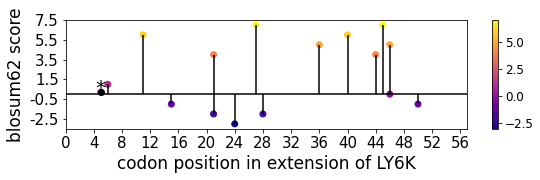

In [546]:
fig, ax = plt.subplots(figsize=(9,2))

ax.vlines(LY6K_df['codon_numb'], ymin=0, ymax=LY6K_df['blosum62_score'])

plt.axhline(y=0, color='black', linestyle='-')

scatter =ax.scatter(LY6K_df['codon_numb'], 
        LY6K_df['blosum62_score'],
        c = LY6K_df['blosum62_score'], cmap='plasma')

ax.text(x=4.2, y = 0, s='*', fontsize=20)

ax.set_xlim(0, 57)

ax.set_xticks(range(0, 59, 4))
ax.set_xticklabels(range(0, 59, 4), fontsize=15)

ax.set_yticks(np.arange(-2.5, 8, 2))
ax.set_yticklabels(np.arange(-2.5, 8, 2), fontsize=15)

ax.set_ylabel('blosum62 score', fontsize=17)
ax.set_xlabel('codon position in extension of LY6K', fontsize=17)

# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    bbox_to_anchor=(1.01, 1.05), title="blosum62 score")
#ax.add_artist(legend1)

ax.scatter(5, 
        0.2,
        c = 'black')

cbar = fig.colorbar(scatter, label='')

cbar.ax.tick_params(labelsize=12)

plt.show()

In [547]:
ext_changes_ann[['gene', 'tr_id', 'HGVSG']].drop_duplicates().groupby(by=['tr_id', 'gene']).count().sort_values(by='HGVSG',
                                                                                                               ascending=False)[0:10]

,,HGVSG
tr_id,gene,
ENST00000439211.6,DHFR,30
ENST00000292430.10,LY6K,16
ENST00000353609.7,FOSB,14
ENST00000296591.9,EDIL3,14
ENST00000254940.9,NIP7,14
ENST00000366607.4,TOMM20,13
ENST00000297578.8,SLC25A32,11
ENST00000505065.1,CDC42SE2,11
ENST00000316788.11,AP3S1,11


In [559]:
FOSB_df = remaining_ext[remaining_ext['gene'] == 'FOSB'][['HGVSG', 'tr_id', 'gene', 
              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons',
                                               'ref_aa', 'alt_aa', 'blosum62_score']].drop_duplicates()

total_num_codons = FOSB_df.iloc[0].total_num_codons

FOSB_df

,HGVSG,tr_id,gene,codon_seq,codon_seq_mut,codon_numb,total_num_codons,ref_aa,alt_aa,blosum62_score
1033,19:g.45468379A>T,ENST00000353609.7,FOSB,GGA,GGT,44,114,G,G,6.0
1034,19:g.45468397T>C,ENST00000353609.7,FOSB,TTT,TTC,50,114,F,F,6.0
1035,19:g.45468431G>A,ENST00000353609.7,FOSB,GAG,AAG,62,114,E,K,1.0
1036,19:g.45468471C>T,ENST00000353609.7,FOSB,TCA,TTA,75,114,S,L,-2.0
1037,19:g.45468475G>T,ENST00000353609.7,FOSB,CCG,CCT,76,114,P,P,7.0
1038,19:g.45468491C>T,ENST00000353609.7,FOSB,CAC,TAC,82,114,H,Y,2.0
1039,19:g.45468498G>A,ENST00000353609.7,FOSB,GGA,GAA,84,114,G,E,-2.0
1040,19:g.45468524G>A,ENST00000353609.7,FOSB,GCC,ACC,93,114,A,T,0.0
1041,19:g.45468540C>T,ENST00000353609.7,FOSB,TCC,TTC,98,114,S,F,-2.0
1042,19:g.45468545C>T,ENST00000353609.7,FOSB,CGA,TGA,100,114,R,*,NaN


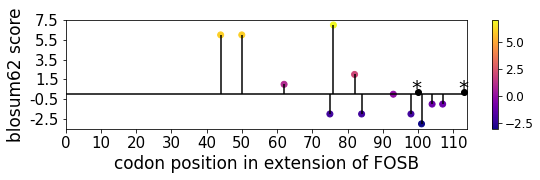

In [563]:
fig, ax = plt.subplots(figsize=(9,2))

ax.vlines(FOSB_df['codon_numb'], ymin=0, ymax=FOSB_df['blosum62_score'])

plt.axhline(y=0, color='black', linestyle='-')

scatter =ax.scatter(FOSB_df['codon_numb'], 
        FOSB_df['blosum62_score'],
        c = FOSB_df['blosum62_score'], cmap='plasma')



ax.set_xlim(0, total_num_codons)

ax.set_xticks(range(0, total_num_codons, 10))
ax.set_xticklabels(range(0, total_num_codons, 10), fontsize=15)

ax.set_yticks(np.arange(-2.5, 8, 2))
ax.set_yticklabels(np.arange(-2.5, 8, 2), fontsize=15)

ax.set_ylabel('blosum62 score', fontsize=17)
ax.set_xlabel('codon position in extension of FOSB', fontsize=17)

# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    bbox_to_anchor=(1.01, 1.05), title="blosum62 score")
#ax.add_artist(legend1)

ax.scatter([100, 113], 
        [0.2, 0.2],
        c = 'black')

ax.text(x=98, y = 0, s='*', fontsize=20)
ax.text(x=111.4, y = 0, s='*', fontsize=20)

cbar = fig.colorbar(scatter, label='')

cbar.ax.tick_params(labelsize=12)

plt.show()

In [564]:
ext_changes_ann[['gene', 'tr_id', 'HGVSG']].drop_duplicates().groupby(by=['tr_id', 'gene']).count().sort_values(by='HGVSG',
                                                                                                               ascending=False)[0:10]

,,HGVSG
tr_id,gene,
ENST00000439211.6,DHFR,30
ENST00000292430.10,LY6K,16
ENST00000353609.7,FOSB,14
ENST00000296591.9,EDIL3,14
ENST00000254940.9,NIP7,14
ENST00000366607.4,TOMM20,13
ENST00000297578.8,SLC25A32,11
ENST00000505065.1,CDC42SE2,11
ENST00000316788.11,AP3S1,11


In [571]:
EDIL3_df = remaining_ext[remaining_ext['gene'] == 'EDIL3'][['HGVSG', 'tr_id', 'gene', 
              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons',
                                               'ref_aa', 'alt_aa', 'blosum62_score']].drop_duplicates()

total_num_codons = EDIL3_df.iloc[0].total_num_codons

EDIL3_df

,HGVSG,tr_id,gene,codon_seq,codon_seq_mut,codon_numb,total_num_codons,ref_aa,alt_aa,blosum62_score
336,5:g.84384378C>G,ENST00000296591.9,EDIL3,GGG,GGG,16,18,G,G,6.0
337,5:g.84384380C>A,ENST00000296591.9,EDIL3,GGG,GGA,16,18,G,G,6.0
341,5:g.84384381G>A,ENST00000296591.9,EDIL3,GAC,AAC,15,18,D,N,1.0
342,5:g.84384388G>T,ENST00000296591.9,EDIL3,CCG,CTG,13,18,P,L,-3.0
343,5:g.84384392G>A,ENST00000296591.9,EDIL3,CGT,CGA,12,18,R,R,5.0
347,5:g.84384392G>C,ENST00000296591.9,EDIL3,CGT,CGC,12,18,R,R,5.0
348,5:g.84384397C>A,ENST00000296591.9,EDIL3,GGG,GAG,10,18,G,E,-2.0
349,5:g.84384399C>A,ENST00000296591.9,EDIL3,CCG,ACG,9,18,P,T,-1.0
350,5:g.84384399C>T,ENST00000296591.9,EDIL3,CCG,TCG,9,18,P,S,-1.0
351,5:g.84384400G>A,ENST00000296591.9,EDIL3,CCG,CAG,9,18,P,Q,-1.0


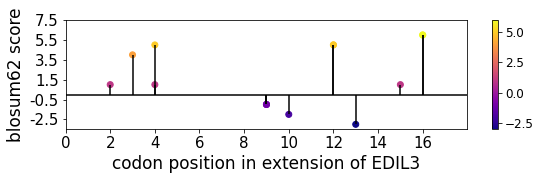

In [573]:
fig, ax = plt.subplots(figsize=(9,2))

ax.vlines(EDIL3_df['codon_numb'], ymin=0, ymax=EDIL3_df['blosum62_score'])

plt.axhline(y=0, color='black', linestyle='-')

scatter =ax.scatter(EDIL3_df['codon_numb'], 
        EDIL3_df['blosum62_score'],
        c = EDIL3_df['blosum62_score'], cmap='plasma')



ax.set_xlim(0, total_num_codons)

ax.set_xticks(range(0, total_num_codons, 2))
ax.set_xticklabels(range(0, total_num_codons, 2), fontsize=15)

ax.set_yticks(np.arange(-2.5, 8, 2))
ax.set_yticklabels(np.arange(-2.5, 8, 2), fontsize=15)

ax.set_ylabel('blosum62 score', fontsize=17)
ax.set_xlabel('codon position in extension of EDIL3', fontsize=17)

# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    bbox_to_anchor=(1.01, 1.05), title="blosum62 score")
#ax.add_artist(legend1)

#ax.scatter([100, 113], 
#        [0.2, 0.2],
#        c = 'black')

#ax.text(x=98, y = 0, s='*', fontsize=20)
#ax.text(x=111.4, y = 0, s='*', fontsize=20)

cbar = fig.colorbar(scatter, label='')

cbar.ax.tick_params(labelsize=12)

plt.show()

In [581]:
NIP7_df = remaining_ext[remaining_ext['gene'] == 'NIP7'][['HGVSG', 'tr_id', 'gene', 
              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons',
                                               'ref_aa', 'alt_aa', 'blosum62_score']].drop_duplicates()

total_num_codons = NIP7_df.iloc[0].total_num_codons

NIP7_df

,HGVSG,tr_id,gene,codon_seq,codon_seq_mut,codon_numb,total_num_codons,ref_aa,alt_aa,blosum62_score
853,16:g.69339722A>C,ENST00000254940.9,NIP7,ACG,CCG,2,38,T,P,-1.0
854,16:g.69339722A>G,ENST00000254940.9,NIP7,ACG,GCG,2,38,T,A,0.0
855,16:g.69339722A>T,ENST00000254940.9,NIP7,ACG,TCG,2,38,T,S,1.0
856,16:g.69339737A>G,ENST00000254940.9,NIP7,AAG,GAG,7,38,K,E,1.0
857,16:g.69339757G>T,ENST00000254940.9,NIP7,GGG,GGT,13,38,G,G,6.0
858,16:g.69339761A>G,ENST00000254940.9,NIP7,AGC,GGC,15,38,S,G,0.0
859,16:g.69339767C>T,ENST00000254940.9,NIP7,CGA,TGA,17,38,R,*,NaN
860,16:g.69339778C>A,ENST00000254940.9,NIP7,TCC,TCA,20,38,S,S,4.0
861,16:g.69339783C>G,ENST00000254940.9,NIP7,TCC,TGC,22,38,S,C,-1.0
862,16:g.69339799G>A,ENST00000254940.9,NIP7,ACG,ACA,27,38,T,T,5.0


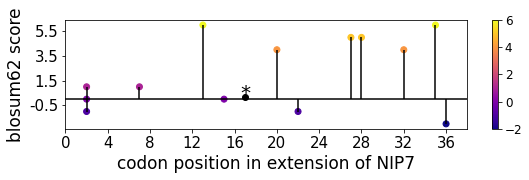

In [583]:
fig, ax = plt.subplots(figsize=(9,2))

ax.vlines(NIP7_df['codon_numb'], ymin=0, ymax=NIP7_df['blosum62_score'])

plt.axhline(y=0, color='black', linestyle='-')

scatter =ax.scatter(NIP7_df['codon_numb'], 
        NIP7_df['blosum62_score'],
        c = NIP7_df['blosum62_score'], cmap='plasma')



ax.set_xlim(0, total_num_codons)

ax.set_xticks(range(0, total_num_codons, 4))
ax.set_xticklabels(range(0, total_num_codons, 4), fontsize=15)

ax.set_yticks(np.arange(-2.5, 8, 2))
ax.set_yticklabels(np.arange(-2.5, 8, 2), fontsize=15)

ax.set_ylabel('blosum62 score', fontsize=17)
ax.set_xlabel('codon position in extension of NIP7', fontsize=17)

# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*scatter.legend_elements(),
#                    bbox_to_anchor=(1.01, 1.05), title="blosum62 score")
#ax.add_artist(legend1)

ax.scatter(17, 
        0.2,
        c = 'black')

ax.text(x=16.5, y = 0, s='*', fontsize=20)

cbar = fig.colorbar(scatter, label='')

cbar.ax.tick_params(labelsize=12)

plt.show()

# We might add interesting genes later 

### Supplementary 

In [382]:
remaining_ext.shape[0]

remaining_ext[['HGVSG', 'tr_id', 'gene', 'global_coo_ext_codons', 'strand', 
              'codon_seq', 'codon_seq_mut', 'codon_numb', 'total_num_codons',
              'Primary site', 'Primary histology', 'Histology subtype 1', 'ref_aa', 
               'alt_aa', 'blosum62_score']].drop_duplicates().to_csv('Supplementary_tables_and_plots/tables/S7_COSMIC_riboset_ext.txt',
                                                                    sep='\t', index=False)